# SPIN-UP phase for the double pendulum system

1. Defining parameters and functions
   1. Parameters
   2. F_deriv
   3. RK4_matrix
   4. Jacobian
   5. Lyapunov exponents
   
2. Spin-up phase
   1. via RK4
   2. via scipy.linalg.expm
   3. Jacobian's eigenvalues

> When the time step is too large, RK4 seems to produce a consistent (constant) bias.
> When the time step is small enough, the two methods give the same results.

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
m1 = 1
m2 = 1
l1 = 1
l2 = 1
g = 9.81

# math labels
lambda_math = r"$\lambda_{max}$"
lambda_n_math = r"$\lambda_{max,n}$"
delta_math = r"$\delta x_0$"
t_max_math = r"$t_{max}$"
t_step_math = r"$t_{step}$"


def F_deriv(w1, w2, th1, th2):
    num1 = -g*(2*m1+m2)*np.sin(th1)-m2*g*np.sin(th1-2*th2)-2*np.sin(th1-th2)*m2*(w2**2*l2+w1**2*l1*np.cos(th1-th2))
    denom1 = l1*(2*m1+m2-m2*np.cos(2*th1-2*th2))
    
    num2 = 2*np.sin(th1-th2)*(w1**2*l1*(m1+m2)+g*(m1+m2)*np.cos(th1)+w2**2*l2*m2*np.cos(th1-th2))
    denom2 = l2*(2*m1+m2-m2*np.cos(2*th1-2*th2))
    
    w1_dot = num1/denom1
    w2_dot = num2/denom2    
    
    return np.array([w1_dot, w2_dot, w1, w2])
   
### Runge-Kutta 4 for matrices ###
def RK4_matrix(A, delta_0, dt, N):
    """ Runge-Kutta 4 scheme for F = A@y """
    y = np.zeros((4, N+1))
    y[:, 0] = delta_0 # delta's initial conditions
    for i in range(N):
        k1 = dt * (A @ y[:, i])
        k2 = dt * (A @ (y[:, i] + k1/2))
        k3 = dt * (A @ (y[:, i] + k2/2))
        k4 = dt * (A @ (y[:, i] + k3))
        y[:, i+1] = y[:, i] + 1/6 * (k1 + 2*k2 + 2*k3 + k4)
    return y

def jacobian(w1, w2, th1, th2):
    jac = np.zeros((4,4))
   
    jac[0][2] = 1 #dth1/dw1
    jac[1][3] = 1 #dth2/w2
    jac[2][2] = -4*m2*w1*np.sin(th1 - th2)*np.cos(th1 - th2)/(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2)
    jac[2][3] = -4*l2*m2*w2*np.sin(th1 - th2)/(l1*(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2))
    jac[3][2] = 4*l1*w1*(m1 + m2)*np.sin(th1 - th2)/(l2*(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2))
    jac[3][3] = 4*m2*w2*np.sin(th1 - th2)*np.cos(th1 - th2)/(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2)
    jac[2][0] = -2*m2*(-g*m2*np.sin(th1 - 2*th2) - g*(2*m1 + m2)*np.sin(th1) - 2*m2*(l1*w1**2*np.cos(th1 - th2) + l2*w2**2)*np.sin(th1 - th2))*np.sin(2*th1 - 2*th2)/(l1*(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2)**2) + (-g*m2*np.cos(th1 - 2*th2) - g*(2*m1 + m2)*np.cos(th1) + 2*l1*m2*w1**2*np.sin(th1 - th2)**2 - 2*m2*(l1*w1**2*np.cos(th1 - th2) + l2*w2**2)*np.cos(th1 - th2))/(l1*(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2))
    jac[2][1] = 2*m2*(-g*m2*np.sin(th1 - 2*th2) - g*(2*m1 + m2)*np.sin(th1) - 2*m2*(l1*w1**2*np.cos(th1 - th2) + l2*w2**2)*np.sin(th1 - th2))*np.sin(2*th1 - 2*th2)/(l1*(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2)**2) + (2*g*m2*np.cos(th1 - 2*th2) - 2*l1*m2*w1**2*np.sin(th1 - th2)**2 + 2*m2*(l1*w1**2*np.cos(th1 - th2) + l2*w2**2)*np.cos(th1 - th2))/(l1*(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2))
    jac[3][0] = -4*m2*(g*(m1 + m2)*np.cos(th1) + l1*w1**2*(m1 + m2) + l2*m2*w2**2*np.cos(th1 - th2))*np.sin(th1 - th2)*np.sin(2*th1 - 2*th2)/(l2*(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2)**2) + 2*(-g*(m1 + m2)*np.sin(th1) - l2*m2*w2**2*np.sin(th1 - th2))*np.sin(th1 - th2)/(l2*(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2)) + 2*(g*(m1 + m2)*np.cos(th1) + l1*w1**2*(m1 + m2) + l2*m2*w2**2*np.cos(th1 - th2))*np.cos(th1 - th2)/(l2*(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2))
    jac[3][1] = 2*m2*w2**2*np.sin(th1 - th2)**2/(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2) + 4*m2*(g*(m1 + m2)*np.cos(th1) + l1*w1**2*(m1 + m2) + l2*m2*w2**2*np.cos(th1 - th2))*np.sin(th1 - th2)*np.sin(2*th1 - 2*th2)/(l2*(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2)**2) - 2*(g*(m1 + m2)*np.cos(th1) + l1*w1**2*(m1 + m2) + l2*m2*w2**2*np.cos(th1 - th2))*np.cos(th1 - th2)/(l2*(2*m1 - m2*np.cos(2*th1 - 2*th2) + m2))
                                                                                   
    return jac

# Lyapunov Exponent Calculator
def lyapunov_RK4(t, delta, N):
    """ Lyapunov exponent calculator for delta_X(t) created through RK4 """
    lya = np.zeros(N)
    norm = np.zeros(N)
    for i in range (N):
        norm[i] = np.linalg.norm(delta[:,i])
    for i in range(N):
        lya[i] = np.log((norm[i])/norm[0])/t[i]
    return lya

def lyapunov_expm(t_delta, delta_a, N):
    """ Lyapunov exponent calculator for delta_X(t) created through matrix exponentials """
    lya = np.zeros(N)
    norm = np.zeros(N)
    for i in range (N):
        norm[i] = np.linalg.norm(delta_a[i])
    
    for i in range(N):
        lya[i] = np.log((norm[i])/norm[0])/t_delta[i]
    return lya

In [7]:
# # Arbitrary initial conditions
w1_0 = 0
w2_0 = 0
th1_0 = 1.8
th2_0 = 1.8
u0 = np.array([w1_0, w2_0, th1_0, th2_0])

# Time parameters
t_max = 100
dt = 0.01
N = int(np.floor(t_max/dt))+1
t_delta = np.linspace(0, t_max, N) # time array

# Arbitrary initial Delta_X
delta_0 = [0, 0, 10**(-10), 0]

# Calling the jacobian function and fixing initial values
J = jacobian(w1_0, w2_0, th1_0, th2_0)

### Solving delta_X(t) with RK4
delta = RK4_matrix(J, delta_0, dt, N)
### Computing the local lyapunov exponent
lya_RK4 = lyapunov_RK4(t_delta, delta, N)

### Solving delta_X(t) with matrix exponentials
delta_a = np.zeros((N,4))
for i in range(N):
    delta_a[i] = sp.linalg.expm(J*t_delta[i]) @ delta_0
### Computing the local lyapunov exponent
lya_expm = lyapunov_expm(t_delta, delta_a, N)

# Verifying with theoretical values of lyapunov_max
eigenvalue, eigenvector = np.linalg.eig(J)
print()
print(f"Eigenvalues of the jacobian matrix when u0 = {u0}:")
print(eigenvalue)
print()
print("Theoretical lyapunov exponent:")
print(f"Lambda_max = {np.max(eigenvalue.real)}")
print()
print("Experimental lyapunov exponent:")
print(f"Lambda_max(t_max) = {lya_expm[-1]}")
print(f"Lambda_max(t=20) = {lya_expm[2000]}") # t = 20 if dt = 0.01
print(f"Lyapunov array average from t=20 to t_max: {np.average(lya_expm[2000:N])}")
print()
print(f"N.B. lyapunov array length = N = {len(lya_expm)}")
print()

C:\Users\Solal\AppData\Local\Temp\ipykernel_24980\2651330052.py:70: RuntimeWarning: invalid value encountered in scalar divide
  lya[i] = np.log((norm[i])/norm[0])/t[i]



Eigenvalues of the jacobian matrix when u0 = [0.  0.  1.8 1.8]:
[-2.75858272 -1.14264237  2.75858272  1.14264237]

Theoretical lyapunov exponent:
Lambda_max = 2.758582716018861

Experimental lyapunov exponent:
Lambda_max(t_max) = 2.7508301564792754
Lambda_max(t=20) = 2.7198199183209257
Lyapunov array average from t=20 to t_max: 2.7429851792555486

N.B. lyapunov array length = N = 10001



C:\Users\Solal\AppData\Local\Temp\ipykernel_24980\2651330052.py:81: RuntimeWarning: invalid value encountered in scalar divide
  lya[i] = np.log((norm[i])/norm[0])/t_delta[i]


### Plot for the SPIN-UP phase

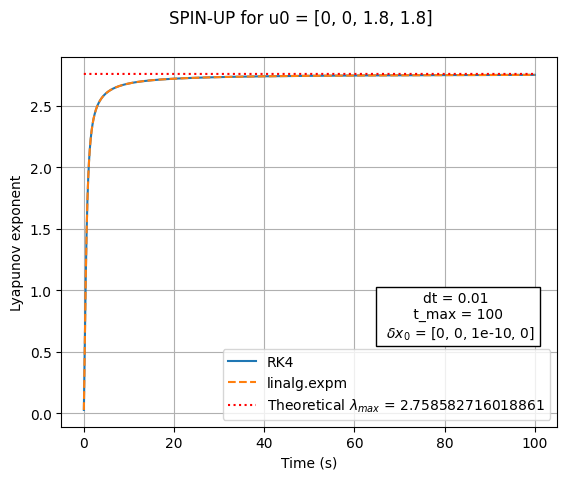

In [8]:
# Plotting the single spin-up results

plt.figure()
plt.plot(t_delta, lya_RK4, label = "RK4")
plt.plot(t_delta, lya_expm, "--", label = "linalg.expm")
plt.plot(t_delta, np.max(eigenvalue.real)*np.ones(N), ":", color = "red", label = f"Theoretical {lambda_math} = {np.max(eigenvalue.real)}")
plt.suptitle(f"SPIN-UP for u0 = [{w1_0}, {w2_0}, {th1_0}, {th2_0}]")
plt.xlabel("Time (s)")
plt.ylabel("Lyapunov exponent")
plt.text(0.8, 0.3, f"dt = {dt} \n t_max = {t_max} \n {delta_math} = {delta_0}", bbox = dict(facecolor = "white", alpha = 1), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.grid()
plt.legend()
plt.savefig(f"lyap_{t_max}_spinup_{th1_0}rad.png")


### Local $\lambda_{max}$ for each initial pair of ($\theta_1$, $\theta_2$) when $\theta_1 = \theta_2 = 0$

We will plot the local $\lambda_{max}$ with respect to the angle $\theta$ when $\theta_{1,0} = \theta_{2,0} = \theta$.

  3%|▎         | 9593/300030 [00:02<01:01, 4739.26it/s]C:\Users\Solal\AppData\Local\Temp\ipykernel_24980\2651330052.py:81: RuntimeWarning: invalid value encountered in scalar divide
  lya[i] = np.log((norm[i])/norm[0])/t_delta[i]
100%|██████████| 300030/300030 [01:36<00:00, 3123.79it/s]


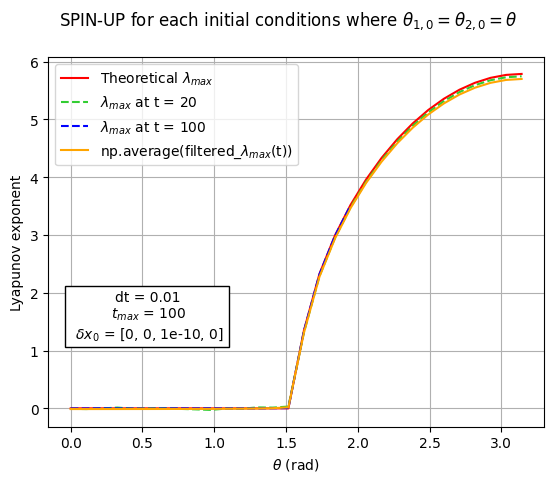

In [9]:
theta_N = 30

th = np.linspace(0,np.pi,theta_N) # Angle array

# initial angle conditions
theta_theta = [np.array([0, 0, th[p], th[p]])  for p in range(theta_N)]
theta_zero = [np.array([0, 0, th[p], 0]) for p in range(theta_N)]
zero_theta = [np.array([0, 0, 0, th[p]]) for p in range(theta_N)]

lyap_spinup1 = np.zeros(theta_N)
lyap_spinup2 = np.zeros(theta_N)
lyap_spinup_ave = np.zeros(theta_N)
lyap_spinup_theo = np.zeros(theta_N)

with tqdm(total=theta_N*N) as pbar: # Progression bar
    for p in range(theta_N):
        Jp = jacobian(0, 0, th[p], th[p])
        delta_ap = np.zeros((N,4))
        for i in range(N):
            delta_ap[i] = sp.linalg.expm(Jp*t_delta[i]) @ delta_0
            pbar.update(1)
        lya_expm_p = lyapunov_expm(t_delta, delta_ap, N) 

        lyap_spinup_theo[p] = np.max(np.linalg.eig(Jp)[0].real)
        lyap_spinup1[p] = lya_expm_p[2000]
        lyap_spinup2[p] = lya_expm_p[10000]
        filtered_lya_expm_p = np.array(lya_expm_p)[np.isfinite(lya_expm_p)] # Filtering the NaN and inf values
        lyap_spinup_ave[p] = np.average(filtered_lya_expm_p)
  
# Plotting the SPIN-UP for each initial conditions
plt.figure()
plt.plot(th, lyap_spinup_theo, color = "red", label = f"Theoretical {lambda_math}")
plt.plot(th, lyap_spinup1, "--", color = "limegreen", label = f"{lambda_math} at t = 20")
plt.plot(th, lyap_spinup2, "--", color = "blue", label = f"{lambda_math} at t = 100")
plt.plot(th, lyap_spinup_ave, color = "orange", label = f"np.average(filtered_{lambda_math}(t))")

plt.suptitle(r"SPIN-UP for each initial conditions where $\theta_{1,0} = \theta_{2,0} = \theta$")
plt.ylabel("Lyapunov exponent")
plt.xlabel(r"$\theta$ (rad)")
plt.text(0.2, 0.3, f"dt = {dt}\n {t_max_math} = {t_max} \n {delta_math} = {delta_0}", bbox = dict(facecolor = "white", alpha = 1), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.legend()
plt.grid()

plt.savefig("local_lyap_theta_theta.png")
plt.show()

As we can see above, there is a clear "flip" at $\theta = \frac{\pi}{2}$.

# Global largest Lyapunov exponent

We can now define a $t_{step}$ and a $n_{step}$ to compute the global largest Lyapunov exponent.

We will show the results for each initial pair of ($\theta_1$, $\theta_2$):
- when $\theta_1 = \theta_2 = \theta$.
- when $\theta_1 = - \theta_2 = \theta$.
- when $\theta_1 = 0$ and $\theta_2 = \theta$.
- when $\theta_1 = \theta$ and $\theta_2 = 0$.

In [14]:

# Time parameters
t_step = 20
dt = 0.01
N = int(np.floor(t_step/dt))+1 # about 2000 timesteps

n_step = 50
theta_N = 30

# Initial dx0
dx0 = np.array([0, 0, 1, 0])
dx0 = dx0/(np.linalg.norm(dx0)*10**10) # so that norm(dx0) = 10**(-10)
    
def last_RK4(f, u0, dt, N):
    """ Returns : u (4x1 array of last computed values)"""
    u = np.zeros(4)
    u = u0
    for i in range(N - 1):
        k1 = dt * f(u[0], u[1], u[2], u[3])
        k2 = dt * f(u[0] + k1[0]/2, u[1] + k1[1]/2, u[2] + k1[2]/2, u[3] + k1[3]/2)
        k3 = dt * f(u[0] + k2[0]/2, u[1] + k2[1]/2, u[2] + k2[2]/2, u[3] + k2[3]/2)
        k4 = dt * f(u[0] + k3[0], u[1] + k3[1], u[2] + k3[2], u[3] + k3[3])
        u = u + 1/6 * (k1 + 2*k2 + 2*k3 + k4)
    return u # last computed set of 4 values

def lyapunov(u, dx, t_step):
    """ Computing lambda_max after t_step seconds, starting from a given u and dx"""
    J = jacobian(u[0],u[1],u[2],u[3]) # evaluating the jacobian at u
    dxf = sp.linalg.expm(J*t_step) @ dx # solving for dx after t seconds
    norm = np.linalg.norm(dxf)
    lyapf = np.log(norm/np.linalg.norm(dx))*1/t_step # Lyapunov exponent after t seconds
    return lyapf, dxf
    
#-------------------------------------------

th = np.linspace(0,np.pi,theta_N) # Angle array

# Templates for initial conditions (u_0)
theta_theta = [np.array([0, 0, th[p], th[p]])  for p in range(theta_N)]
theta_minustheta = [np.array([0, 0, th[p], -th[p]]) for p in range(theta_N)]
theta_zero = [np.array([0, 0, th[p], 0]) for p in range(theta_N)]
zero_theta = [np.array([0, 0, 0, th[p]]) for p in range(theta_N)]

def global_lyaps(u_0, dx0, dt, last_RK4, F_deriv, lyapunov, n_step, theta_N):
    """Computes the global largest lyapunov exponents for different initial conditions"""

    lya_th = np.zeros(theta_N) # "Lyapunov for each angle" array

    steps = theta_N*n_step
    with tqdm(total=steps) as pbar: # Progression bar
        for p in range(theta_N):
            u0 = u_0[p]
            lya_steps= np.zeros(n_step)
            for i in range(n_step):
                u1 = last_RK4(F_deriv, u0, dt, N) # updating th1, th2, w1, w2
                lya_steps[i], dx = lyapunov(u0, dx0, t_step) # computing the lyapunov exponent
                u0 = u1 # updating initial conditions
                dx0 = dx/(np.linalg.norm(dx)*10**10) # Renormalising so that norm(dx0) = 10**(-10)
                pbar.update(1)  # Updates the progression bar
            lya_th[p] = np.average(lya_steps) 
            # filtered_lya_th = np.array(lya_th)[np.isfinite(lya_th)] # Filtering the NaN and inf values
            # lya_th_ave[p] = np.average(filtered_lya_th)
    return lya_th

def graph_lyaps(th, lya_th, u_0):
    """ Plots the Lyapunov exponents for different initial conditions"""

    if all(np.array_equal(a, b) for a, b in zip(u_0, theta_theta)):
        title = r"Initial conditions: $\theta_{1,0}= \theta_{2,0} = \theta$ ; $\omega_{1,0} = \omega_{2,0} = 0$"
        filename = "global_lyap_theta_theta.png"
    elif all(np.array_equal(a, b) for a, b in zip(u_0, theta_minustheta)):
        title = r"Initial conditions: $\theta_{1,0} = \theta$, $\theta_{2,0} = -\theta$ ; $\omega_{1,0} = \omega_{2,0} = 0$"
        filename = "global_lyap_theta_minustheta.png"
    elif all(np.array_equal(a, b) for a, b in zip(u_0, theta_zero)):
        title = r"Initial conditions: $\theta_{1,0} = \theta$, $\theta_{2,0} = 0$ ; $\omega_{1,0} = \omega_{2,0} = 0$"
        filename = "global_lyap_theta_zero.png"
    elif all(np.array_equal(a, b) for a, b in zip(u_0, zero_theta)):
        title = r"Initial conditions: $\theta_{1,0} = 0$, $\theta_{2,0} = \theta$ ; $\omega_{1,0} = \omega_{2,0} = 0$"
        filename = "global_lyap_zero_theta.png"
    
    plt.figure()
    plt.plot(th, lya_th, label = f"{lambda_n_math} average")
    plt.suptitle(title)
    plt.ylabel("Lyapunov exponent")
    plt.xlabel(r"$\theta$ (rad)")
    plt.text(0.2, 0.7, f"dt = {dt} \n {t_max_math} = n*{t_step_math} = 50*20\n {delta_math} = [0,0,1e-10,0]", bbox = dict(facecolor = "white", alpha = 1), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.legend()
    plt.grid()
    plt.savefig(filename)


100%|██████████| 1500/1500 [02:32<00:00,  9.83it/s]


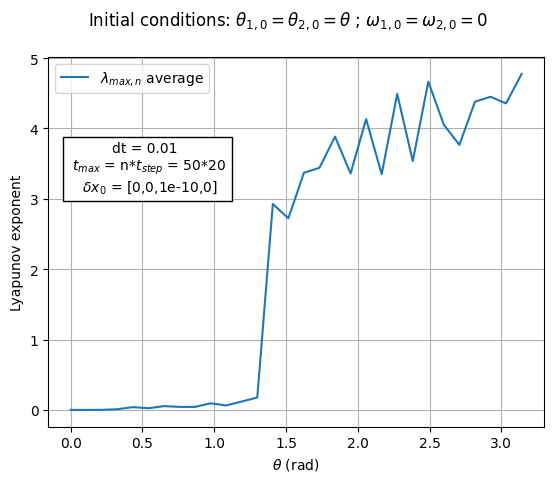

In [15]:
lyap_theta_theta = global_lyaps(theta_theta, dx0, dt, last_RK4, F_deriv, lyapunov, n_step, theta_N)
graph_lyaps(th, lyap_theta_theta, theta_theta)
plt.show()

As we can see above, for the $\theta_{1,0} = \theta_{2,0} = \theta$ case, the critical angle seems to be at around $\theta = 1.38 rad$. 

100%|██████████| 1500/1500 [02:39<00:00,  9.42it/s]


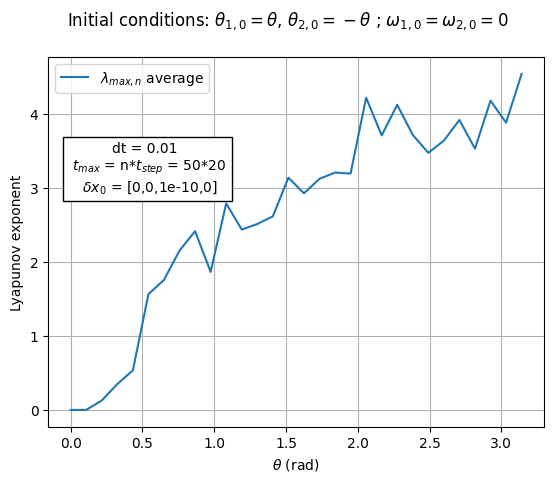

In [16]:
lyap_theta_minustheta = global_lyaps(theta_minustheta, dx0, dt, last_RK4, F_deriv, lyapunov, n_step, theta_N)
graph_lyaps(th, lyap_theta_minustheta, theta_minustheta)
plt.show()

100%|██████████| 1500/1500 [02:41<00:00,  9.29it/s]


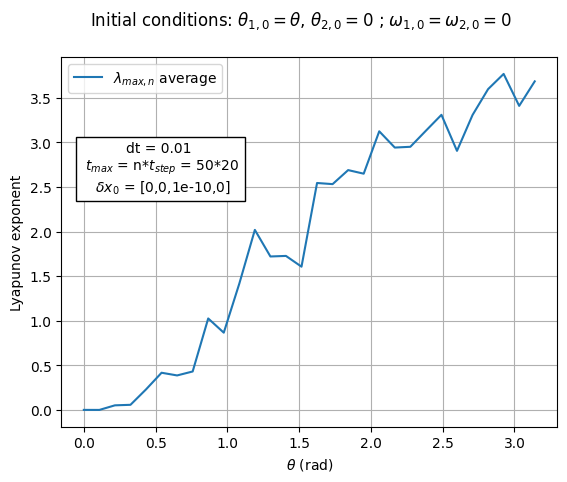

In [17]:
lyap_theta_zero = global_lyaps(theta_zero, dx0, dt, last_RK4, F_deriv, lyapunov, n_step, theta_N)
graph_lyaps(th, lyap_theta_zero, theta_zero)
plt.show()

100%|██████████| 1500/1500 [03:12<00:00,  7.80it/s]


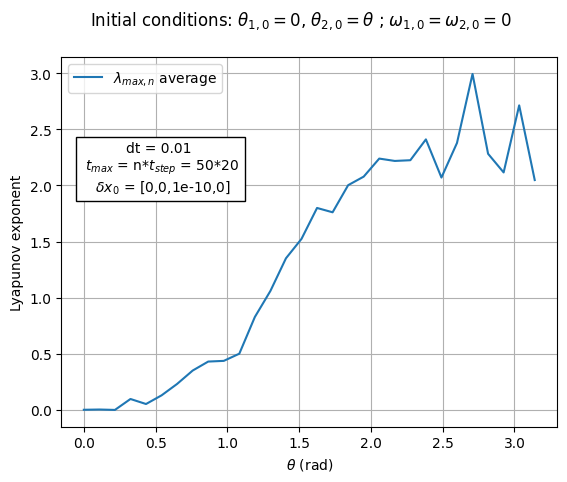

In [18]:
lyap_zero_theta = global_lyaps(zero_theta, dx0, dt, last_RK4, F_deriv, lyapunov, n_step, theta_N)
graph_lyaps(th, lyap_zero_theta, zero_theta)
plt.show()